### Imports and data preparation

In [1]:
import numpy as np
#from numpy.random import multivariate_normal
from scipy.stats import multivariate_normal
from sklearn.preprocessing import scale
from scipy.stats import truncnorm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
import time

# Initialize random seed for replication
np.random.seed(4)

In [2]:
raw_data = np.fromfile("german.data-numeric", sep=" ")

In [3]:
# From the documentation, we know that the data is composed of 1000 samples
nb_samples, nb_features = 1000, 24
raw_data = raw_data.reshape(nb_samples,nb_features+1)
print(raw_data.shape)

# Linear transform to set the labels in {-1, 1}, as in the model
raw_data[:,-1] = 2 * raw_data[:,-1] -3

(1000, 25)


### Question 1: bias and normalization

In [4]:
# Add a constant column in the features
data = np.concatenate((np.ones((nb_samples,1)), raw_data), axis=-1)
nb_features += 1
print(data.shape)

# Create indexes for features and label
idx_features = range(nb_features)
idx_labels = (nb_features)

# Normalize the features. Do not normalize first column
data[:,idx_features[1:]] = scale(data[:,idx_features[1:]], axis=0)

# Assert normalization is as expected
print(np.mean(data[:,0]))
print(np.var(data[:,0]))
print(np.mean(data[:,1]))
print(np.var(data[:,1]))
print(np.mean(data[:,idx_labels]))
print(np.var(data[:,idx_labels]))

(1000, 26)
1.0
0.0
3.019806626980426e-17
0.9999999999999998
-0.4
0.8399999999999997


### Question 3: Gibbs Sampling

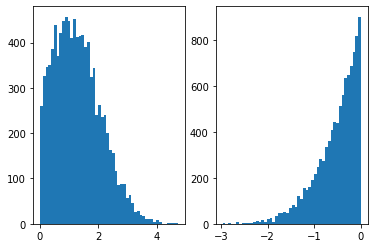

In [5]:
# Test the truncated normal function from scipy
mean = np.array([1,1])
a = np.array([0, -float('Inf')])-mean
b = np.array([float('Inf'), 0])-mean
liste = []

for i in range(10000):
    liste.append(truncnorm.rvs(a, b, loc=mean))
    
plt.figure()
plt.subplot(1,2,1)
plt.hist([liste[i][0] for i in range(10000)], bins=50)
plt.subplot(1,2,2)
plt.hist([liste[i][1] for i in range(10000)], bins=50)
plt.show()

In [6]:
class gibbs_sampler_probit:
    def __init__(self, tau, X, Y):
        self.X = X
        self.Y = Y
        self.tau = tau
        self.n, self.p = X.shape
        
        self.sigma = np.linalg.inv(np.eye(self.p)/tau + X.T @ X)
        self.a = np.where(Y==1, 0, -float('Inf'))
        self.b = np.where(Y==1, float('Inf'), 0)
        
        self.beta = np.zeros(self.p)
        self.Z = np.zeros(self.n)
        self.sampled_beta = []
        self.sampled_z = []
        
    def reset(self):
        self.beta = np.zeros(self.p)
        self.Z = np.zeros(self.n)
        self.sampled_beta = []
        self.sampled_z = []

    def beta_sampling(self):
        mu = self.sigma @ self.X.T @ self.Z
        self.beta = np.random.multivariate_normal(mu, cov=self.sigma)
    
    def Z_sampling(self):
        mu = self.X@self.beta
        self.Z = truncnorm.rvs(self.a-mu, self.b-mu, loc=mu)
    
    def run_sampling(self, burn_in_steps, nb_samples):
        self.reset()
        for i in range(burn_in_steps+nb_samples):
            self.Z_sampling()
            self.beta_sampling()
            if i>=burn_in_steps:
                self.sampled_z.append(self.Z)
                self.sampled_beta.append(self.beta)
        return(self.sampled_beta, self.sampled_z)
    
    def predict(self, X):
        Z = X@self.beta
        return np.where(Z>0, 1, -1)

In [7]:
tau = 100
burn_in_steps = 10000
nb_draws = 10000
# Split the dataset in 4/5 | 1/5 for train/test
cut = int(4*nb_samples/5)
data_train = data[:cut]
data_test = data[cut:]
# Sample and learn beta
gs_model = gibbs_sampler_probit(tau, data_train[:,:-1], data_train[:,-1])
sampled_beta, sampled_z = gs_model.run_sampling(burn_in_steps, nb_draws)

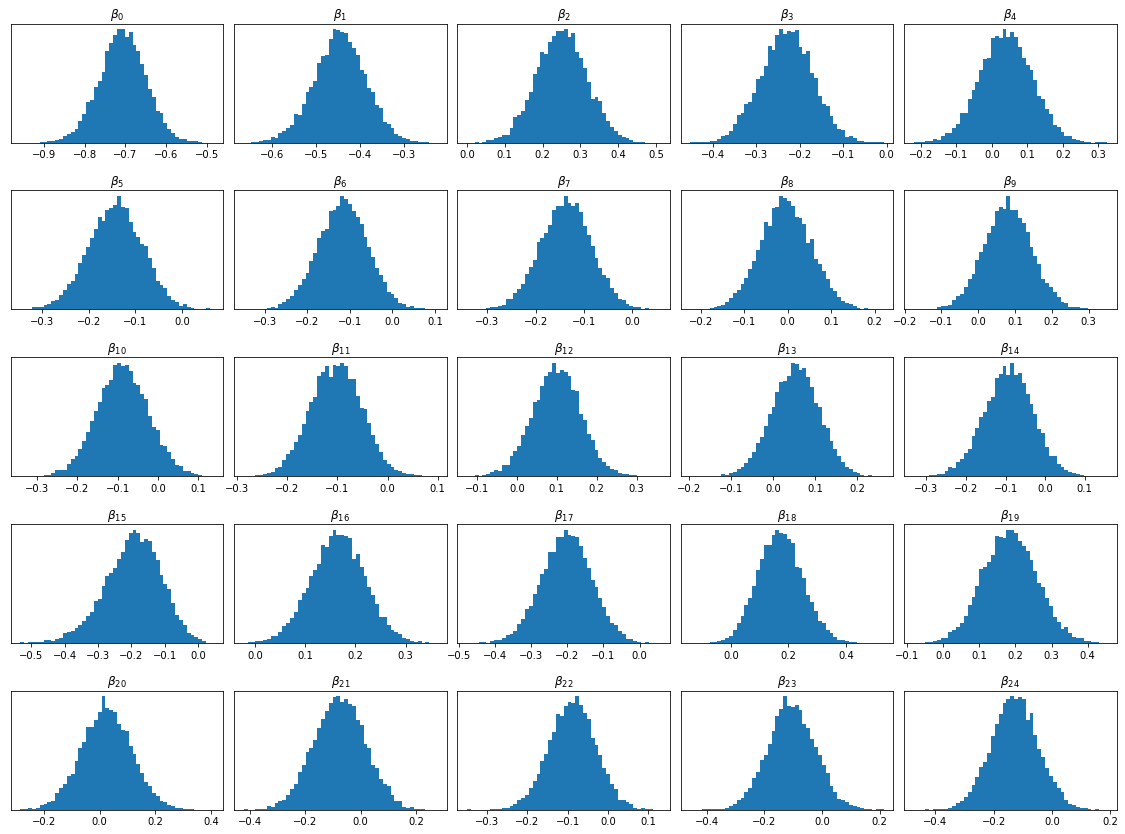

In [8]:
nb_param = sampled_beta[0].size
nb_draws = len(sampled_beta)

# Plot the distributions of beta parameters

plt.figure(figsize=(16,12))

for i in range(nb_param):
    fig = plt.subplot(5,5,i+1)
    plt.title(r'$\beta_{%d}$'%i)
    fig.axes.get_yaxis().set_visible(False)
    plt.hist([sampled_beta[j][i] for j in range(nb_draws)], bins=50)

plt.subplots_adjust(wspace=0.05, hspace=0.4, left=0.02, right=0.98, bottom=0.04, top=0.95)
#plt.savefig('beta_posterior_gibbs.jpg')
plt.show()
    

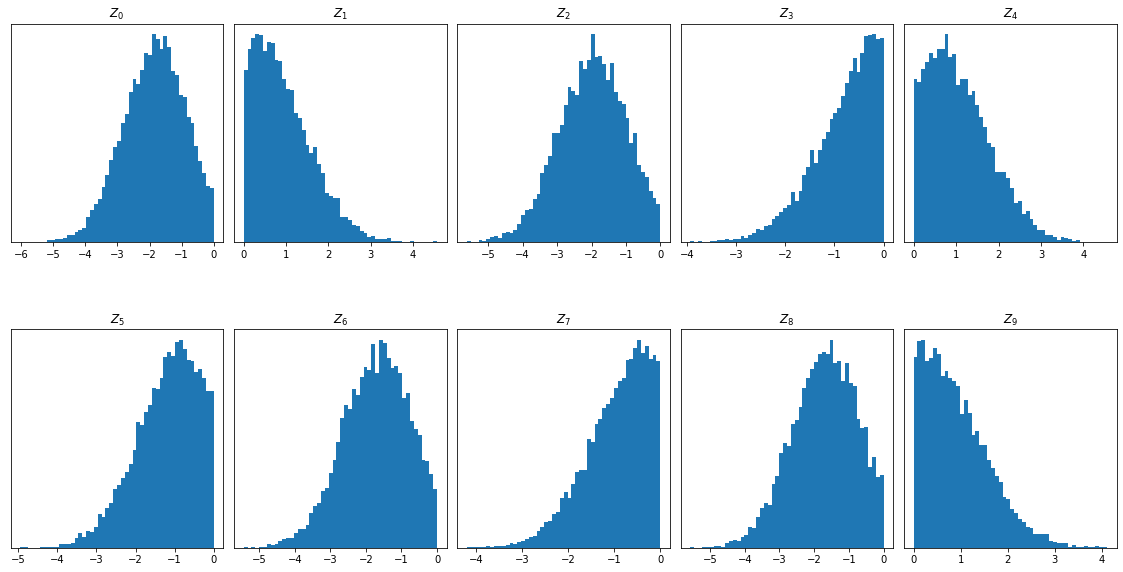

In [9]:
plt.figure(figsize=(16,8))

# Plot the distribution of some Z

for i in range(10):
    fig = plt.subplot(2,5,i+1)
    plt.title(r'$Z_{%d}$'%i)
    fig.axes.get_yaxis().set_visible(False)
    plt.hist([sampled_z[j][i] for j in range(nb_draws)], bins=50)

plt.subplots_adjust(wspace=0.05, hspace=0.4, left=0.02, right=0.98, bottom=0.04, top=0.95)
#plt.savefig('Z_gibbs.jpg')
plt.show()

In [10]:
# Evaluate the accuracy of the model on train data

pred = gs_model.predict(data_test[:,:-1])
print(accuracy_score(data_test[:,-1], pred))

0.765


### Question 4: Mean Field

In [11]:
class meanfield_iterator_probit:
    def __init__(self, tau, X, Y):
        self.X = X
        self.Y = Y
        self.tau = tau
        self.n, self.p = X.shape
        
        self.sigma = np.linalg.inv(np.eye(self.p)/tau + X.T @ X)
        self.a = np.where(Y==1, 0, -float('Inf'))
        self.b = np.where(Y==1, float('Inf'), 0)
        
        self.beta = np.zeros(self.p)
        self.Z = np.zeros(self.n)
    
    def reset(self):
        self.beta = np.zeros(self.p)
        self.Z = np.zeros(self.n)
    
    def compute_beta(self):
        self.beta = self.sigma @ self.X.T @ self.Z
    
    def compute_Z(self):
        mu2 = self.X @ self.beta
        pdf = multivariate_normal.pdf(mu2)
        cdf = multivariate_normal.cdf(self.Y * mu2)
        self.Z = mu2 + self.Y * pdf / cdf
    
    def run_iterations(self, nb_iter):
        self.reset()
        for i in range(nb_iter):
            self.compute_beta()
            self.compute_Z()
            
    def sample(self, nb_draws):
        mu2 = self.X @ self.beta
        beta_values = multivariate_normal.rvs(self.beta, self.sigma, size=nb_draws)
        z_values = truncnorm.rvs(self.a-mu2, self.b-mu2, loc=mu2, size=(nb_draws, self.n))
        return beta_values, z_values
    
    def predict(self, X):
        Z = X@self.beta
        return np.where(Z>0, 1, -1)

In [12]:
# Iterate and learn the parameters
nb_iter = 1000
mf_model = meanfield_iterator_probit(tau, data_train[:,:-1], data_train[:,-1])
mf_model.run_iterations(nb_iter)
beta_samples_mf, z_samples_mf = mf_model.sample(nb_draws)

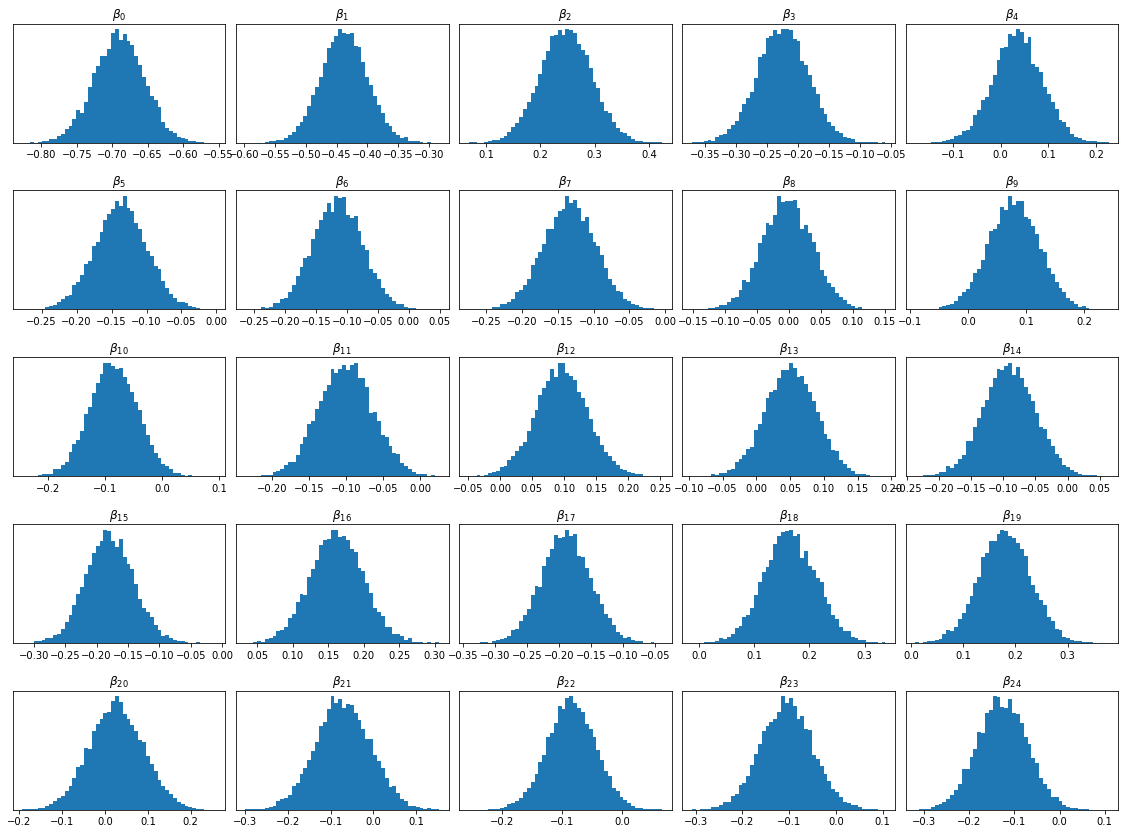

In [13]:
# Plot the distributions of beta parameters
plt.figure(figsize=(16,12))

for i in range(nb_param):
    fig = plt.subplot(5,5,i+1)
    plt.title(r'$\beta_{%d}$'%i)
    fig.axes.get_yaxis().set_visible(False)
    plt.hist(beta_samples_mf[:,i], bins=50)

plt.subplots_adjust(wspace=0.05, hspace=0.4, left=0.02, right=0.98, bottom=0.04, top=0.95)
#plt.savefig('beta_posterior_meanfield.jpg')
plt.show()

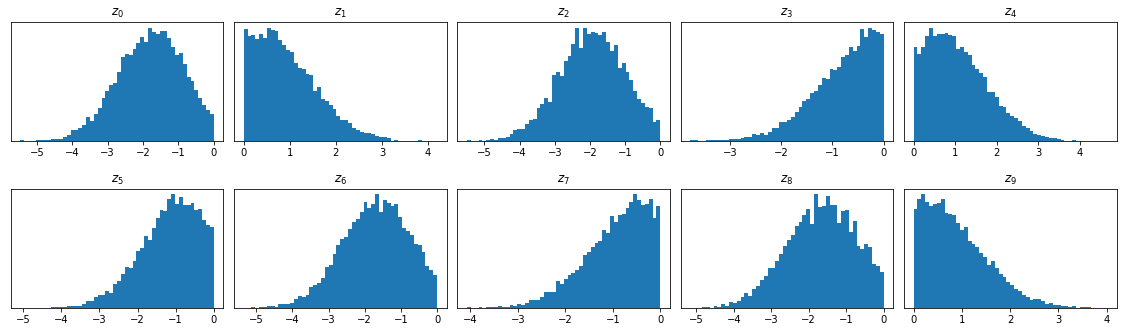

In [14]:
# Plot the distributions of beta parameters
plt.figure(figsize=(16,12))

for i in range(10):
    fig = plt.subplot(5,5,i+1)
    plt.title(r'$z_{%d}$'%i)
    fig.axes.get_yaxis().set_visible(False)
    plt.hist(z_samples_mf[:,i], bins=50)

plt.subplots_adjust(wspace=0.05, hspace=0.4, left=0.02, right=0.98, bottom=0.04, top=0.95)
#plt.savefig('z_posterior_meanfield.jpg')
plt.show()

In [15]:
# Evaluate the accuracy of the model on train data

pred = mf_model.predict(data_test[:,:-1])
print(accuracy_score(data_test[:,-1], pred))

0.785


In [16]:
# Compare the models for various numbers of steps to evaluate speed and accuracy
#nb_steps corresponds to nb_draws for gibbs and to nb_iter for Mean Field
nb_steps_list = [10, 100, 500, 1000, 5000, 10000]
burn_in_steps = 500
models = {'Gibbs sampling': gs_model, 'Mean Field': mf_model}

times = {'gs':[], 'mf':[]}
accuracies = {'gs':[], 'mf':[]}
variations = {'gs':[], 'mf':[]}

for nb_steps in nb_steps_list:
    print('nb_step:', nb_steps)
    
    t = time.time()
    gs_beta, gs_z = gs_model.run_sampling(burn_in_steps, nb_steps)
    times['gs'].append(time.time()-t)
    t = time.time()
    mf_model.run_iterations(nb_steps)
    mf_beta, mf_z = mf_model.sample(nb_steps) # To get the same nb of samples as for gibbs
    times['mf'].append(time.time()-t)
    t=time.time()
    
    pred_gs = gs_model.predict(data_test[:,:-1])
    pred_mf = mf_model.predict(data_test[:,:-1])
    accuracies['gs'].append(accuracy_score(data_test[:,-1], pred_gs))
    accuracies['mf'].append(accuracy_score(data_test[:,-1], pred_mf))
    
    gs_beta = np.asarray(gs_beta)
    variations['gs'].append(np.mean(np.var(gs_beta, axis=0)))
    variations['mf'].append(np.mean(np.var(mf_beta, axis=0)))

nb_step: 10
nb_step: 100
nb_step: 500
nb_step: 1000
nb_step: 5000
nb_step: 10000


{'gs': [0.4797706604003906, 0.5643165111541748, 0.9316368103027344, 1.4037747383117676, 5.133192539215088, 9.814644813537598], 'mf': [0.03760790824890137, 0.3710641860961914, 1.8229742050170898, 3.68133544921875, 18.541876077651978, 37.122358560562134]}
{'gs': [0.775, 0.785, 0.75, 0.77, 0.77, 0.77], 'mf': [0.785, 0.785, 0.785, 0.785, 0.785, 0.785]}
{'gs': [0.0041715011199399184, 0.004515558837322498, 0.004588569346207221, 0.004615971840537623, 0.004547814570231858, 0.004549316831097004], 'mf': [0.0016424581700539805, 0.0019883148111935612, 0.001965746786168751, 0.002029233291489614, 0.0020137278341998584, 0.002003173173302631]}


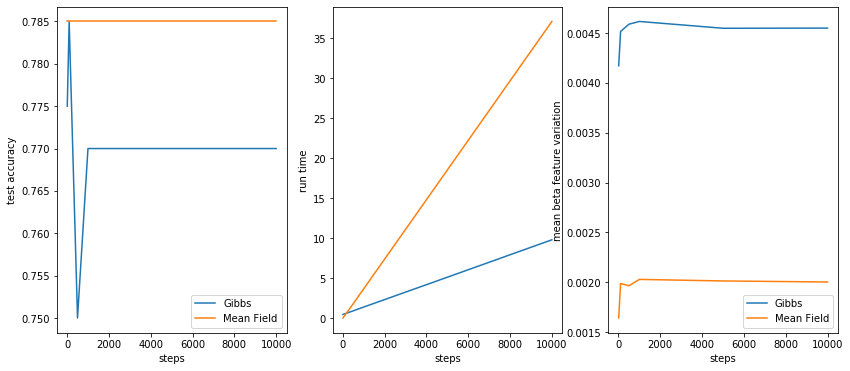

In [17]:
# Plot the comparison of the models
print(times)

print(accuracies)

print(variations)

plt.figure(figsize=(14,6))

plt.subplot(1,3,1)
plt.plot(nb_steps_list, accuracies['gs'], label='Gibbs')
plt.plot(nb_steps_list, accuracies['mf'], label='Mean Field')
plt.xlabel('steps')
plt.ylabel('test accuracy')
plt.legend()

plt.subplot(1,3,2)
plt.plot(nb_steps_list, times['gs'], label='Gibbs')
plt.plot(nb_steps_list, times['mf'], label='Mean Field')
plt.xlabel('steps')
plt.ylabel('run time')

plt.subplot(1,3,3)
plt.plot(nb_steps_list, variations['gs'], label='Gibbs')
plt.plot(nb_steps_list, variations['mf'], label='Mean Field')
plt.xlabel('steps')
plt.ylabel('mean beta feature variation')

#plt.savefig('comparison.jpg')
plt.legend()

### Question 6: Separable Dataset

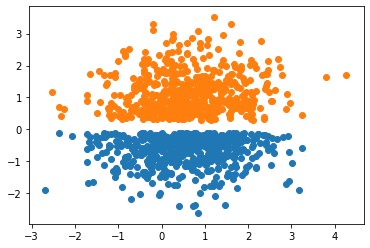

In [18]:
# Build a separable dataset
mean = np.array([0.5,0.5])
sep_a = np.array([-float('inf'), -float('inf')])
sep_b = np.array([float('inf'), -0.1])

features_a = truncnorm.rvs(sep_a-mean-0.2, sep_b-mean, loc=mean, size=(500, 2))
features_b = truncnorm.rvs(-sep_b-mean+0.2, -sep_a-mean, loc=mean, size=(500,2))

plt.figure()
plt.scatter(features_a[:,0], features_a[:,1])
plt.scatter(features_b[:,0], features_b[:,1])
plt.show()

In [19]:
# Add labels
set_a = np.concatenate((features_a, np.full((500,1), 1)), axis=1)
set_b = np.concatenate((features_b, np.full((500,1), -1)), axis=1)

# Concatenate and shuffle
sep_data = np.concatenate((set_a, set_b), axis=0)
np.random.shuffle(sep_data)

# Normalize and add bias
sep_data[:,:-1] = scale(sep_data[:,:-1], axis=0)
sep_data = np.concatenate((np.ones((nb_samples,1)), sep_data), axis=-1)

sep_data_train = sep_data[:800]
sep_data_test = sep_data[800:]

In [20]:
# Run gibbs sampling
burn_in_steps = 100
nb_draws = 5000
# Sample and learn beta
sep_model = gibbs_sampler_probit(tau, sep_data_train[:,:-1], sep_data_train[:,-1])
sampled_beta, sampled_z = sep_model.run_sampling(burn_in_steps, nb_draws)

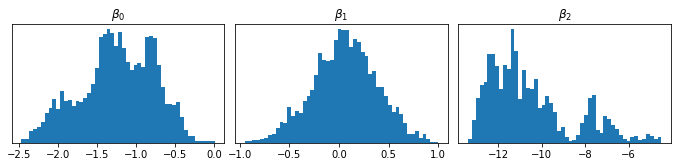

In [21]:
nb_param = sampled_beta[0].size
nb_draws = len(sampled_beta)

# Plot the distributions of beta parameters

plt.figure(figsize=(16,12))

for i in range(nb_param):
    fig = plt.subplot(5,5,i+1)
    plt.title(r'$\beta_{%d}$'%i)
    fig.axes.get_yaxis().set_visible(False)
    plt.hist([sampled_beta[j][i] for j in range(nb_draws)], bins=50)

plt.subplots_adjust(wspace=0.05, hspace=0.4, left=0.02, right=0.98, bottom=0.04, top=0.95)
plt.savefig('separable_gibbs.jpg')
plt.show()

In [22]:
# Evaluate the accuracy of the model on train data

pred = sep_model.predict(sep_data_test[:,:-1])
print(accuracy_score(sep_data_test[:,-1], pred))

1.0
